# Experiments

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np
import time
import seaborn as sns

from models import *
from utils import *
from train import *

sns.set(font_scale=1.2)
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

try:
    if torch.backend.mpas.is_available():
        device = torch.device('mps')
except:
    torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Approximate BNNs
### Feedforward BNN

In [2]:
X_train, Y_train = load_data('./data/', 'abnn_ff_train_256_0.5_4_0.5.pkl')
X_test, Y_test = load_data('./data/', 'abnn_ff_test_256_0.5_4_0.5.pkl')
X_valid, Y_valid = load_data('./data/', 'abnn_ff_valid_256_0.5_4_0.5.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [3]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30,
    **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.6700641810894012, time elapsed: 0 h 2 m 56 s
2th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.6808474659919739, time elapsed: 0 h 5 m 44 s
3th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.6812590062618256, time elapsed: 0 h 8 m 31 s
4th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.6446159034967422, time elapsed: 0 h 11 m 19 s
5th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.6668617129325867, time elapsed: 0 h 14 m 7 s
6th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.7260499596595764, time elapsed: 0 h 16 m 52 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.6661280393600464, time elapsed: 0 h 19 m 38 s
8th repeat: best hidden unit: 256, best layers: 4, final eval loss: 1.6908062398433685, time elapsed: 0 h 22 m 19 s
9th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.661928

Best hidden unit: 256, best layers: 3


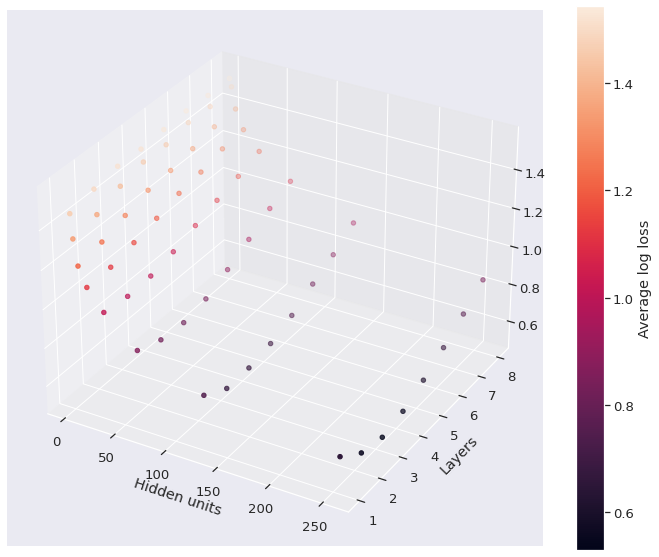

In [4]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log loss', fname='param_search_log_ff')

####  2. Learning with best parameter

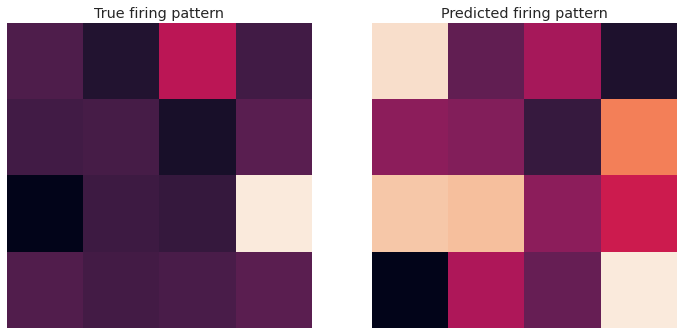

Initial eval loss: 4.6933910846710205
Epoch 1: training loss 36.971997767686844, eval loss 3.1242674589157104. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 29.11742076277733, eval loss 2.7155623137950897. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 25.97406142950058, eval loss 2.446341872215271. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 23.720835000276566, eval loss 2.26437771320343. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 21.755600959062576, eval loss 2.0886777341365814. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 20.386455833911896, eval loss 1.9807746708393097. Time elapsed: 0 h 0 m 0 s.
Epoch 7: training loss 19.108930602669716, eval loss 1.875606507062912. Time elapsed: 0 h 0 m 1 s.
Epoch 8: training loss 17.861584693193436, eval loss 1.8012462556362152. Time elapsed: 0 h 0 m 1 s.
Epoch 9: training loss 16.8479984998703, eval loss 1.7853142023086548. Time elapsed: 0 h 0 m 1 s.
Epoch 10: training loss 16.174857407808304, eval loss 1.74046452343463

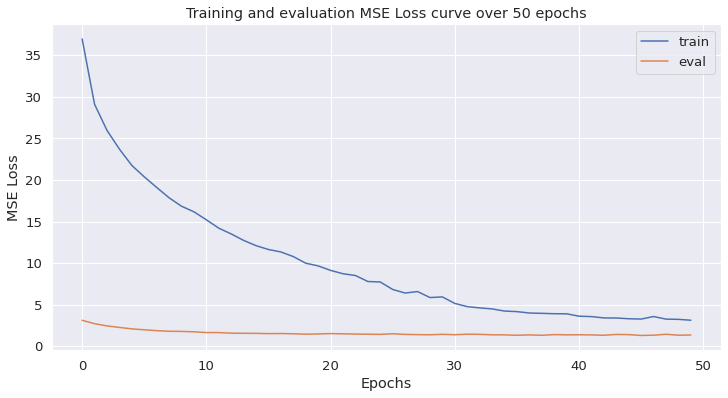

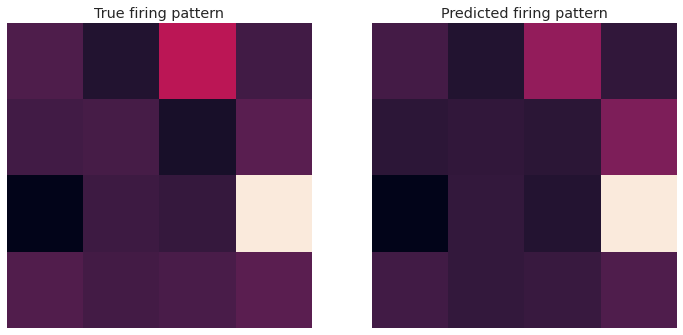

In [5]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=3, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_train[13,:], DNN(X_train[13,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_train[13,:], DNN(X_train[13,:])) # visualise after training

#### 3. Testing against predicting the mean

In [6]:
with torch.no_grad():
    pred_mean = DNN(X_train)
    
print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0), Y_test))

DNN prediction MSE error on test set:  tensor(0.2707, device='cuda:0', grad_fn=<MseLossBackward0>)
Predicting mean MSE error on test set tensor(0.9366, device='cuda:0')


/tmp/ipykernel_12236/4047130697.py:5: UserWarning: Using a target size (torch.Size([1000, 16])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0), Y_test))


### Residual BNN

In [2]:
X_train, Y_train = load_data('./data/', 'abnn_resid_train_256_0.5_4_0.5.pkl')
X_test, Y_test = load_data('./data/', 'abnn_resid_test_256_0.5_4_0.5.pkl')
X_valid, Y_valid = load_data('./data/', 'abnn_resid_valid_256_0.5_4_0.5.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [3]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.3419833183288574, time elapsed: 0 h 2 m 15 s
2th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.3247351050376892, time elapsed: 0 h 4 m 37 s
3th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.31125959753990173, time elapsed: 0 h 7 m 0 s
4th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.28119367361068726, time elapsed: 0 h 9 m 23 s
5th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.31096720695495605, time elapsed: 0 h 11 m 47 s
6th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.30913951992988586, time elapsed: 0 h 14 m 9 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.3124375641345978, time elapsed: 0 h 16 m 32 s
8th repeat: best hidden unit: 256, best layers: 2, final eval loss: 0.33619803190231323, time elapsed: 0 h 18 m 55 s
9th repeat: best hidden unit: 256, best layers: 2, final eval loss: 0.305

Best hidden unit: 256, best layers: 3


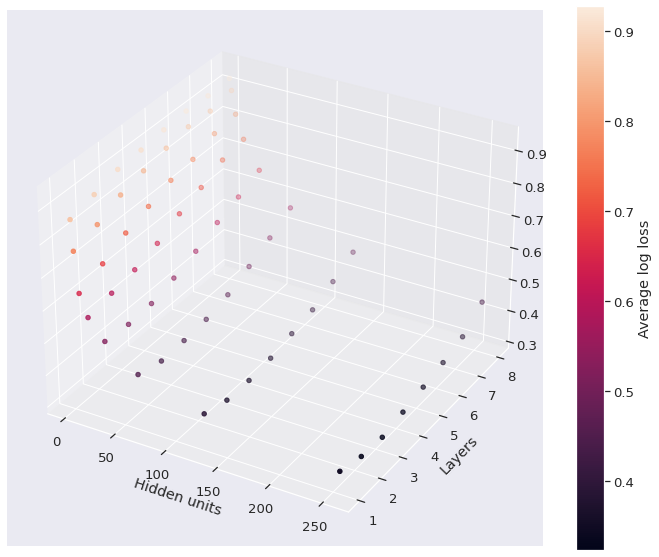

In [4]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average log loss', fname='param_search_resid')

#### 2. Learning with best parameter

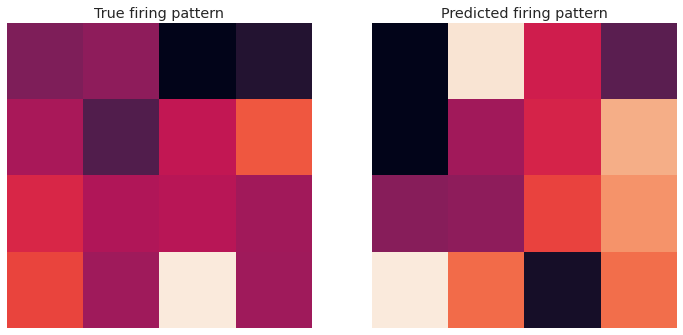

Initial eval loss: 0.9300094246864319
Epoch 1: training loss 35.904356092214584, eval loss 0.5903996229171753. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 27.449106246232986, eval loss 0.5156199932098389. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 24.187988847494125, eval loss 0.46143969893455505. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 21.409180909395218, eval loss 0.4267937242984772. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 19.228083610534668, eval loss 0.4071599245071411. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 17.59186552464962, eval loss 0.3698301911354065. Time elapsed: 0 h 0 m 0 s.
Epoch 7: training loss 16.339549720287323, eval loss 0.3657236695289612. Time elapsed: 0 h 0 m 0 s.
Epoch 8: training loss 15.497594460844994, eval loss 0.3626905679702759. Time elapsed: 0 h 0 m 0 s.
Epoch 9: training loss 14.751573726534843, eval loss 0.34587621688842773. Time elapsed: 0 h 0 m 0 s.
Epoch 10: training loss 14.008292958140373, eval loss 0.34179

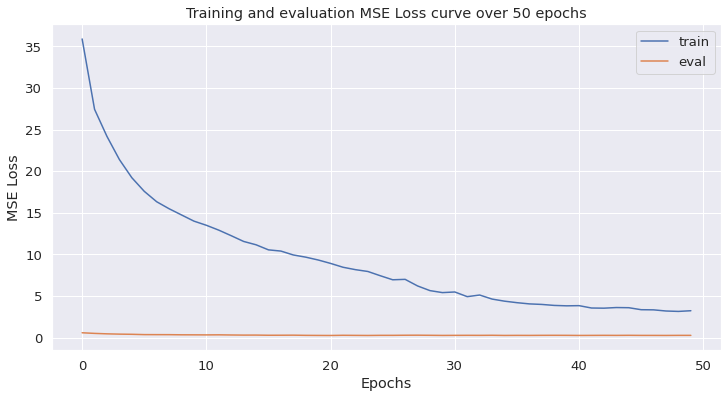

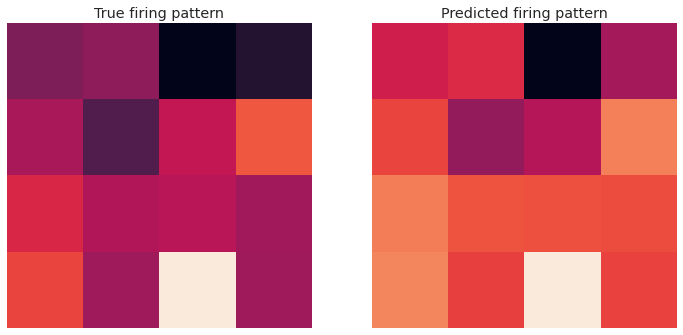

In [10]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=3, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_train[v_idx,:], DNN(X_train[v_idx,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_train[v_idx,:], DNN(X_train[v_idx,:])) # visualise after training

#### 3. Testing against predicting the mean

In [11]:
with torch.no_grad():
    pred_mean = DNN(X_train)
    
print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0), Y_test))

DNN prediction MSE error on test set:  tensor(0.2790, device='cuda:0', grad_fn=<MseLossBackward0>)
Predicting mean MSE error on test set tensor(0.9281, device='cuda:0')


/tmp/ipykernel_12236/4047130697.py:5: UserWarning: Using a target size (torch.Size([100, 16])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0), Y_test))


### Recurrent RNN

In [2]:
X_train, Y_train = load_data('./data/', 'abnn_recur_train_256_0.5_4_0.5.pkl')
X_test, Y_test = load_data('./data/', 'abnn_recur_test_256_0.5_4_0.5.pkl')
X_valid, Y_valid = load_data('./data/', 'abnn_recur_valid_256_0.5_4_0.5.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

In [3]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'RNN', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

1th repeat: best hidden unit: 256, best layers: 6, final eval loss: 1.3748337924480438, time elapsed: 0 h 3 m 5 s
2th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.3825750052928925, time elapsed: 0 h 6 m 26 s
3th repeat: best hidden unit: 256, best layers: 1, final eval loss: 1.3809826076030731, time elapsed: 0 h 9 m 52 s
4th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.3844006955623627, time elapsed: 0 h 13 m 21 s
5th repeat: best hidden unit: 256, best layers: 7, final eval loss: 1.3805657923221588, time elapsed: 0 h 16 m 49 s
6th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.382154405117035, time elapsed: 0 h 20 m 17 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.3811891078948975, time elapsed: 0 h 23 m 43 s
8th repeat: best hidden unit: 256, best layers: 6, final eval loss: 1.3844658732414246, time elapsed: 0 h 27 m 12 s
9th repeat: best hidden unit: 256, best layers: 7, final eval loss: 1.3815234

Best hidden unit: 256, best layers: 6


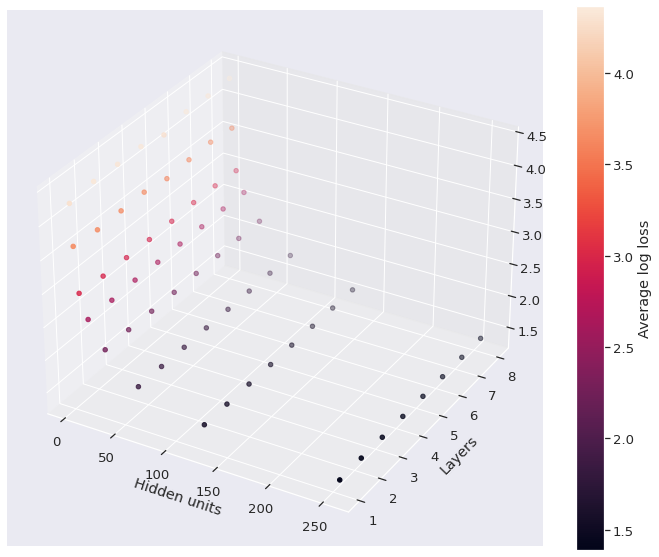

In [4]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average log loss', fname='param_search_recur')

#### 2. Learning with best parameter

Initial eval loss: 5.142711162567139
Epoch 1: training loss 38.75469094514847, eval loss 2.8720242381095886. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 26.480375349521637, eval loss 2.498098462820053. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 23.776890069246292, eval loss 2.2462926506996155. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 21.270955711603165, eval loss 2.0109099447727203. Time elapsed: 0 h 0 m 1 s.
Epoch 5: training loss 19.198043823242188, eval loss 1.839792937040329. Time elapsed: 0 h 0 m 1 s.
Epoch 6: training loss 17.802721321582794, eval loss 1.7319134175777435. Time elapsed: 0 h 0 m 1 s.
Epoch 7: training loss 16.93441951274872, eval loss 1.6647124290466309. Time elapsed: 0 h 0 m 1 s.
Epoch 8: training loss 16.3756260573864, eval loss 1.6193476915359497. Time elapsed: 0 h 0 m 2 s.
Epoch 9: training loss 15.97793698310852, eval loss 1.5847788453102112. Time elapsed: 0 h 0 m 2 s.
Epoch 10: training loss 15.669197916984558, eval loss 1.55732524394989

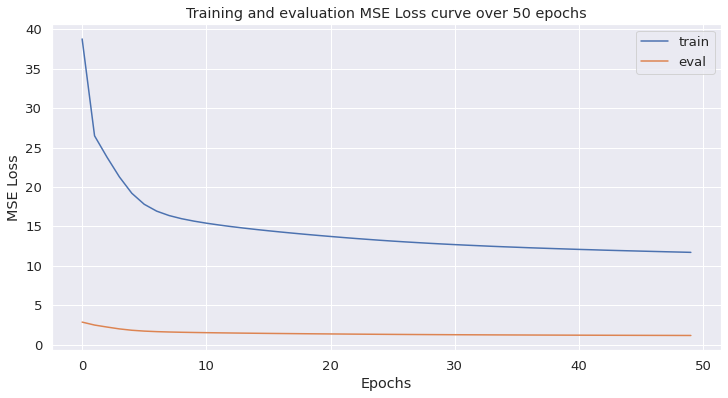

In [5]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=6, output_dim=16, n_lstm_layers=1).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_losses, eval_losses = train_rnn(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

In [22]:
Y_hat

NameError: name 'Y_hat' is not defined

In [ ]:
torch.cuda.empty_cache()

In [6]:
torch.backend.mps.is_available()

AttributeError: module 'torch' has no attribute 'backend'